In [4]:
import numpy as np
def map_clip(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip( a*old+b*np.dot(coup,old)+.40*b*bias+np.random.normal(0,noi,len(old)),-.4,.4)
def ising_energy(stuff,ad,bias):
    return -0.5*1*np.dot(stuff,np.dot(ad,stuff))-np.sum(np.dot(bias,stuff))
def ising_sample(array,NN,n_hid,noise,_a,_b):   
    global result
    global ens2
    global ad
    global chain
    global bias
    test=np.array(array)
    N=int(np.max(test)) #number of nodes
    ad=np.zeros((N,N)) #adjacency matrix
    for i in range(0,len(test)): #initialize
        ad[int(test[i,0])-1,int(test[i,1])-1]+=(test[i,2])
    bias=np.zeros(N)
    for i in range(0,N):
        bias[i]+=ad[i,i]
        ad[i,i]=0
    # parameters for alpha and beta
    a=_a
    b=_b
    noise_strength=noise
    chain=np.zeros(N)
    ens2=np.zeros(NN)
    result=[]
    for i in range(0,NN):
        chain=map_clip(chain,ad,bias,a,b,noise_strength)
        chain_a=np.sign(chain)
        ens2[i]=ising_energy(chain_a,ad,bias)
        result.append(ens2[i])
    result=np.array(result)
    return result
##计算频率的函数
def calculate(array):
    counter = Counter(array)
    numbers = np.array(list(counter.keys()))  # 数的大小
    frequencies = np.array(list(counter.values()))  # 频率
    all_counts=np.sum(frequencies)
    P=frequencies/all_counts
        # 将 numbers 和 P 配对
    paired = list(zip(numbers, P))
    # 按 numbers 的值进行排序（默认升序）
    paired_sorted = sorted(paired, key=lambda x: x[0])
    # 解压排序后的结果
    numbers, P= zip(*paired_sorted)
    return np.array(numbers),np.array(P)

In [5]:
import numpy as np
k=1
T=1.8 ##修改温度
flip_prob=(np.exp(-(4)/(k*T)))
ens=np.zeros(0)
def ising_energy(stuff,ad,bias):
    return -0.5*1*np.dot(stuff,np.dot(ad,stuff))-np.sum(np.dot(bias,stuff))
def flip2(e_new,e_old,new,old):
    flip_prob=(np.exp(-(e_new-e_old)/(k*T)))
    if(np.random.rand()<flip_prob):
        return new
    else:
        return old
def flip(stuff,index,ad,bias):
    temp=np.copy(stuff)
    temp[index]=-1*temp[index]
    temp_energy=ising_energy(temp,ad,bias)
    energy=ising_energy(stuff,ad,bias)
    global ens
    #ens=np.append(ens,energy)
    if(temp_energy<=energy):
        return temp
    else:
        return flip2(temp_energy,energy,temp,stuff)
    
def mcmc_sample(NN,n_hid,array):   
    test=array #edge list
    N=int(np.max(test)) #number of nodes
    ad=np.zeros((N,N)) #adjacency matrix
    for i in range(0,len(test)): #initialize
        ad[int(test[i,0])-1,int(test[i,1])-1]+=(test[i,2])
    bias=np.zeros((N,N))
    for i in range(0,N):
        bias[i,i]+=ad[i,i]
        ad[i,i]=0
    chain=np.ones(N)##np.sign(np.random.rand(N)*2+0.01-1)
    ens2=np.zeros((N,int(NN/1-1000)))
    result=[]
    for i in range(0,NN):
        #chain=flip(chain,int(np.random.rand()*N))    #random update order
        chain=flip(chain,i%N,ad,bias)   #typewirter update order, does not work well in 1D, better in 2D
        if(i>1000 and i%1==0):
            #if(i%1000==0):
                #print(i)
            result.append(ising_energy(chain,ad,bias))
    return np.array(result)

In [2]:
import random
import pandas as pd
# 设置随机数种子以确保结果可重复         生成矩阵  每个节点和上下左右四个节点连接  
random.seed(42)  # 可以选择任意整数作为种子值
# 初始化边列表
def out_ans(N):
    edges = []
    # 添加水平边
    rows=N
    cols=N ###结点数为N*N
    random_num=-1
    for row in range(rows):
        for col in range(cols - 1):  # 每行最多有 cols-1 条水平边
            node1 = row * cols + col + 1  # 当前节点编号
            node2 = node1 + 1             # 右侧相邻节点编号
            edges.append([node1, node2,random_num])
            edges.append([node2, node1,random_num])
    # 添加垂直边
    for col in range(cols):
        for row in range(rows - 1):  # 每列最多有 rows-1 条垂直边
            node1 = row * cols + col + 1  # 当前节点编号
            node2 = node1 + cols          # 下方相邻节点编号
            edges.append([node1, node2, random_num])
            edges.append([node2, node1, random_num])
    return np.array(edges)
matrix=out_ans(10)
print(matrix.shape)
# 转换为 DataFrame 并写入 txt 文件
df = pd.DataFrame(matrix)
df.to_csv('matrix.txt', header=False, index=False, sep=' ')  # 不写入表头和索引，用逗号分隔
print("矩阵已成功写入 matrix.txt 文件")

(360, 3)
矩阵已成功写入 matrix.txt 文件


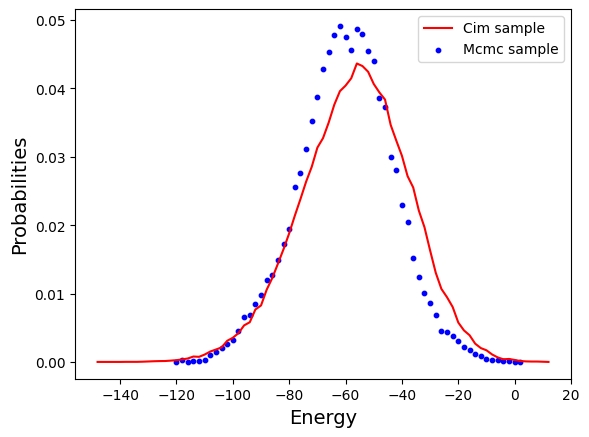

In [24]:
"T=3.4时和noise=0.19对应"
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.linear_model import TheilSenRegressor
from scipy import stats
noise=0.19
a=0.8
b=0.1
NN=90000
n_hid=2
array=np.loadtxt(r'matrix.txt',delimiter=' ', dtype=np.float64) #edge list
data2=mcmc_sample(NN,n_hid,array) ##采样mcmc采样
numbers,P=calculate(data2)
data=ising_sample(array,NN,n_hid,noise,a,b) ##采样ising采样
numbers1,P1=calculate(data)
plt.plot(numbers1, P1, 'r-', label='Cim sample')
plt.scatter(numbers, P,c='blue',s=10,label='Mcmc sample')
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Probabilities', fontsize=14)
# 显示图例
plt.legend()

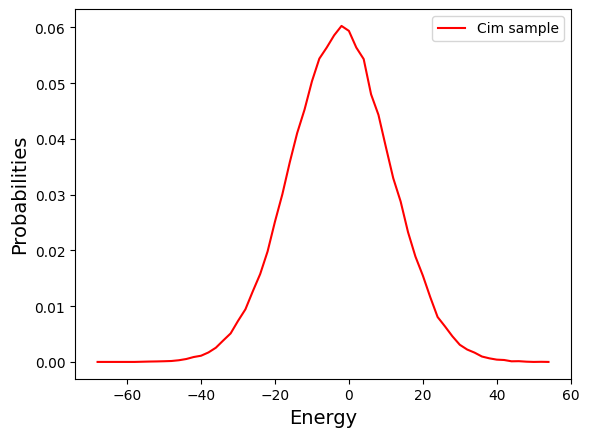

In [20]:
"T=3.4时和noise=0.19对应"
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.linear_model import TheilSenRegressor
from scipy import stats
noise=1
a=0.8
b=0.1
NN=90000
n_hid=2
array=np.loadtxt(r'matrix.txt',delimiter=' ', dtype=np.float64) #edge list
# data2=mcmc_sample(NN,n_hid,array) ##采样mcmc采样
# numbers,P=calculate(data2)
data=ising_sample(array,NN,n_hid,noise,a,b) ##采样ising采样
numbers1,P1=calculate(data)
plt.plot(numbers1, P1, 'r-', label='Cim sample')
# plt.scatter(numbers, P,c='blue',s=10,label='Mcmc sample')
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Probabilities', fontsize=14)
# 显示图例
plt.legend()

In [16]:
import numpy as np

# 初始化一个100x100的零矩阵
J = np.zeros((100, 100))

# 定义网格大小
N = 10
a=0.6
# 遍历每个节点
for m in range(100):
    # 上方邻居
    if m >= N:
        J[m, m - N] = -1
        J[m - N, m] = -1
    # 下方邻居
    if m < 100 - N:
        J[m, m + N] = -1
        J[m + N, m] = -1
    # 左侧邻居
    if m % N != 0:
        J[m, m - 1] = -1
        J[m - 1, m] = -1
    # 右侧邻居
    if (m + 1) % N != 0:
        J[m, m + 1] = -1
        J[m + 1, m] = -1

# 输出耦合矩阵
print(J)
eigenvalues, eigenvectors = np.linalg.eig(0.1*J+a*np.eye(100))
print(eigenvalues)
print(eigenvectors)

[[ 0. -1.  0. ...  0.  0.  0.]
 [-1.  0. -1. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ... -1.  0. -1.]
 [ 0.  0.  0. ...  0. -1.  0.]]
[0.21620281 0.98379719 0.26349859 0.93650141 0.9601493  0.9601493
 0.2398507  0.92287074 0.92287074 0.2398507  0.86194429 0.27712926
 0.89922285 0.89922285 0.33805571 0.8749816  0.30077715 0.27712926
 0.81405515 0.3250184  0.30077715 0.85133371 0.34866629 0.8749816
 0.82036156 0.3250184  0.34866629 0.37963844 0.85133371 0.76616601
 0.79671367 0.82036156 0.40328633 0.81405515 0.38594485 0.43383399
 0.79671367 0.37963844 0.38594485 0.44056489 0.76343563 0.75943511
 0.73978774 0.40328633 0.73978774 0.76343563 0.75943511 0.43656437
 0.43656437 0.71154597 0.46021226 0.44056489 0.46021226 0.71154597
 0.6851677  0.70881559 0.70881559 0.70250918 0.70250918 0.65692594
 0.54307406 0.6851677  0.49118441 0.48845403 0.48845403 0.5148323
 0.66092645 0.62364789 0.49118441 0.49749082 0.49749082 0.5148323
 0.62364